In [29]:
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
pd.options.mode.chained_assignment = None 
import matplotlib
import gc
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
from matplotlib import cm
from math import *
#plotting
from bokeh.layouts import gridplot
from bokeh.plotting import figure
import bokeh.io
from bokeh.io import output_notebook, show
from bokeh.transform import linear_cmap
from bokeh.util.hex import hexbin
from bokeh.palettes import Category20c
from bokeh.transform import cumsum
from bokeh.models import LabelSet, ColumnDataSource
output_notebook()


import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
from tensorflow.keras.models import load_model
from keras_layer_normalization import LayerNormalization
from keras import regularizers
from keras.layers import merge
from sklearn import preprocessing
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from keras.layers import Embedding
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from sklearn.model_selection import GridSearchCV
from keras.layers.normalization import BatchNormalization
from keras.initializers import Constant
from keras.regularizers import l2
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import keras.callbacks 
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
from keras.losses import mean_squared_error
import os 
import datetime, warnings, scipy 
from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
from keras.layers.advanced_activations import PReLU
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate, Dropout
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.optimizers import Adam

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")

Loading BokehJS ...

# Loading train/val/test Data files

In [3]:
X_train = pd.read_csv('../Chengdu Data/X_train.csv')
Y_train = pd.read_csv('../Chengdu Data/Y_train.csv')
X_val = pd.read_csv('../Chengdu Data/X_val.csv')
Y_val = pd.read_csv('../Chengdu Data/Y_val.csv')
X_test = pd.read_csv('../Chengdu Data/X_test.csv')
Y_test = pd.read_csv('../Chengdu Data/Y_test.csv')

In [4]:
# transfer columns which need to be embedded into type 'object'

X_train[['pickup_cluster', 'dropoff_cluster', 'pickup_geohash', 'dropoff_geohash']]= X_train[['pickup_cluster', 'dropoff_cluster', 'pickup_geohash', 'dropoff_geohash']].astype('object')
X_val[['pickup_cluster', 'dropoff_cluster', 'pickup_geohash', 'dropoff_geohash']]= X_val[['pickup_cluster', 'dropoff_cluster', 'pickup_geohash', 'dropoff_geohash']].astype('object')
X_test[['pickup_cluster', 'dropoff_cluster', 'pickup_geohash', 'dropoff_geohash']]= X_test[['pickup_cluster', 'dropoff_cluster', 'pickup_geohash', 'dropoff_geohash']].astype('object')


In [5]:
print('X_test shape =', X_test.shape)
print('Y_test shape =', Y_test.shape)
print('X_train shape =', X_train.shape)
print('Y_train shape =', Y_train.shape)
print('X_val shape =', X_val.shape)
print('Y_val shape =', Y_val.shape)

X_test shape = (20000, 46)
Y_test shape = (20000, 1)
X_train shape = (64000, 46)
Y_train shape = (64000, 1)
X_val shape = (16000, 46)
Y_val shape = (16000, 1)


### Convert data to match the network structure

In [6]:
embed_cols=[i for i in X_train.select_dtypes(include=['object'])]


def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)

     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test

### Merge embedding values

In [7]:
X_train_list,X_val_list,X_test_list = preproc(X_train,X_val, X_test)

### Implementation of the model parts

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import gc
import json
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf

### Layer definitions.

In [9]:
concat = tf.keras.backend.concatenate
stack = tf.keras.backend.stack
K = tf.keras.backend
Add = tf.keras.layers.Add
LayerNorm = tf.keras.layers.LayerNormalization
Dense = tf.keras.layers.Dense
Multiply = tf.keras.layers.Multiply
Dropout = tf.keras.layers.Dropout
Activation = tf.keras.layers.Activation
Lambda = tf.keras.layers.Lambda

### Layer utility functions. MLP, GLU, Add & Norm

In [10]:
def linear_layer(size,
                 activation=None,
                 use_time_distributed=False,
                 use_bias=True):
    """Returns simple Keras linear layer.
       Args:
            size: Output size
            activation: Activation function to apply if required
            use_time_distributed: Whether to apply layer across time
            use_bias: Whether bias should be included in layer
    """
    linear = tf.keras.layers.Dense(size, activation=activation, use_bias=use_bias)
    if use_time_distributed:
        linear = tf.keras.layers.TimeDistributed(linear)
    return linear


def apply_mlp(inputs,
              hidden_size,
              output_size,
              output_activation=None,
              hidden_activation='elu',
              use_time_distributed=False):
    """Applies simple feed-forward network to an input.
       Args:
            inputs: MLP inputs
            hidden_size: Hidden state size
            output_size: Output size of MLP
            output_activation: Activation function to apply on output
            hidden_activation: Activation function to apply on input
            use_time_distributed: Whether to apply across time
       Returns:
               Tensor for MLP outputs.
    """
    if use_time_distributed:
        hidden = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hidden_size, activation=hidden_activation))(inputs)
        return tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_size, activation=output_activation))(hidden)
    else:
        hidden = tf.keras.layers.Dense(hidden_size, activation=hidden_activation)(inputs)
        return tf.keras.layers.Dense(output_size, activation=output_activation)(hidden)


def apply_gating_layer(x,
                       hidden_layer_size,
                       dropout_rate=None,
                       use_time_distributed=True,
                       activation='elu'):
    """Applies a Gated Linear Unit (GLU) to an input.
       Args:
            x: Input to gating layer
            hidden_layer_size: Dimension of GLU
            dropout_rate: Dropout rate to apply if any
            use_time_distributed: Whether to apply across time
            activation: Activation function to apply to the linear feature transform if necessary
       Returns:
               Tuple of tensors for: (GLU output, gate)
    """

    if dropout_rate is not None:
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    if use_time_distributed:
        activation_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hidden_layer_size, activation=activation))(x)
        gated_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hidden_layer_size, activation='elu'))(x)
    else:
        activation_layer = tf.keras.layers.Dense(hidden_layer_size, activation=activation)(x)
        gated_layer = tf.keras.layers.Dense(hidden_layer_size, activation='elu')(x)

    return tf.keras.layers.Multiply()([activation_layer, gated_layer]), gated_layer


def add_and_norm(x_list):
    """Applies skip connection followed by layer normalisation.
       Args:
            x_list: List of inputs to sum for skip connection
       Returns:
               Tensor output from layer.
     """
    tmp = Add()(x_list)
    tmp = LayerNorm()(tmp)
    return tmp



### GRN - Gated Redidual Networ

In [11]:
def gated_residual_network(x, hidden_layer_size, output_size=None, dropout_rate=None, use_time_distributed=False,
                           additional_context=None, return_gate=False):
    """Applies the gated residual network (GRN) as defined in paper.
       Args:
            x: Network inputs
            hidden_layer_size: Internal state size
            output_size: Size of output layer
            dropout_rate: Dropout rate if dropout is applied
            use_time_distributed: Whether to apply network across time dimension
            additional_context: Additional context vector to use if relevant
            return_gate: Whether to return GLU gate for diagnostic purposes
      Returns:
              Tuple of tensors for: (GRN output, GLU gate)
    """

  # Setup skip connection
    if output_size is None:
        output_size = hidden_layer_size
        skip = x
    else:
        linear = Dense(output_size)
        if use_time_distributed:
            linear = tf.keras.layers.TimeDistributed(linear)
        skip = linear(x)

    # Apply feedforward network
    hidden = linear_layer(hidden_layer_size, activation=None, use_time_distributed=False)(x)
    if additional_context is not None:
        hidden = hidden + linear_layer(hidden_layer_size, activation=None, 
                                       use_time_distributed=use_time_distributed, use_bias=False)(additional_context)
    hidden = tf.keras.layers.Activation('elu')(hidden)
    hidden = linear_layer(hidden_layer_size, activation=None, use_time_distributed=False)(hidden)

    gating_layer, gate = apply_gating_layer(hidden, output_size, dropout_rate=dropout_rate, 
                                            use_time_distributed=False, activation=None)

    if return_gate:
        return add_and_norm([skip, gating_layer]), gate
    else:
        return add_and_norm([skip, gating_layer])


### Scaled Dot-Product Attention

In [12]:
class ScaledDotProductAttention():
    
    def __init__(self, attn_dropout=0.0):
        self.dropout = Dropout(attn_dropout)
        self.activation = Activation('elu')
        
        
    def __call__(self, q, k, v, mask):
        
        qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention = qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)  

        weights = self.activation(scaled_attention)
        output = tf.matmul(weights, v)

        return output, weights

### MHA -  Multi-Head Attention

In [13]:
class InterpretableMultiHeadAttention():
    """Defines interpretable multi-head attention layer.
       Attributes:
                  n_head: Number of heads
                  d_k: Key/query dimensionality per head
                  d_v: Value dimensionality
                  dropout: Dropout rate to apply
                  qs_layers: List of queries across heads
                  ks_layers: List of keys across heads
                  vs_layers: List of values across heads
                  attention: Scaled dot product attention layer
                  w_o: Output weight matrix to project internal state to the original state size
    """

    def __init__(self, n_head, d_model, dropout):
        """Initialises layer.
        Args:
             n_head: Number of heads
             d_model: state dimensionality
             dropout: Dropout discard rate
        """

        self.n_head = n_head
        self.d_k = self.d_v = d_k = d_v = d_model // n_head
        self.dropout = dropout

        self.qs_layers = []
        self.ks_layers = []
        self.vs_layers = []

        # Use same value layer to facilitate interp
        vs_layer = Dense(d_v, use_bias=False)

        for _ in range(n_head):
            self.qs_layers.append(Dense(d_k, use_bias=False))
            self.ks_layers.append(Dense(d_k, use_bias=False))
            self.vs_layers.append(vs_layer)  # use same vs_layer

        self.attention = ScaledDotProductAttention()
        self.w_o = Dense(d_model, use_bias=False)

    def __call__(self, q, k, v, mask=None):
        """Applies interpretable multihead attention.
           Using T to denote the number of time steps fed into the transformer.
           Args:
                q: Query tensor of shape=(?, T, d_model)
                k: Key of shape=(?, T, d_model)
                v: Values of shape=(?, T, d_model)
                mask: Masking if required with shape=(?, T, T)
           Returns:
                   Tuple of (layer outputs, attention weights)
        """
        n_head = self.n_head

        heads = []
        attns = []
        for i in range(n_head):
            qs = self.qs_layers[i](q)
            ks = self.ks_layers[i](k)
            vs = self.vs_layers[i](v)
            head, attn = self.attention(qs, ks, vs, None)
            head_dropout = Dropout(self.dropout)(head)
            heads.append(head_dropout)
            attns.append(attn)
            
        head = K.stack(heads) if n_head > 1 else heads[0]
        attn = K.stack(attns)

        outputs = K.mean(head, axis=0) if n_head > 1 else head
        outputs = self.w_o(outputs)
        outputs = Dropout(self.dropout)(outputs) 

        return outputs, attn

# Building GSTA Model

In [14]:
GSTA = None # clear any previous model

Emb_list = []
input_models=[]
output_embeddings=[]
spatial_in = []
sp_in = []
temp_in = []
weather_in = []
extracted_in = []
spatio_temp = []
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
temporal = ['DayofMonth_sin', 'DayofMonth_cos', 'Hour_sin','Hour_cos', 'dayofweek_sin','dayofweek_cos']
weather = ['tempm', 'dewptm', 'hum', 'rain', 'snow', 'wdird', 'vism', 'fog', 'thunder', 'tornado','conds_Clear',
                           'conds_Haze', 'conds_Heavy Rain', 'conds_Heavy Snow', 'conds_Light Rain', 'conds_Light Snow']
extracted = ['distance_haversine', 'distance_dummy_manhattan', 'direction',
                          'avg_speed_KMperHour', 'dropoff_pca0', 'dropoff_pca1', 'pickup_pca0',
                          'pickup_pca1', 'Public_Holiday', 'Weekend_day', 'Work_day', 'Peak_Hour',
                          'pickup_counts_on_clusterid', 'dropoff_counts_on_clusterid']
spatials = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
            'center_latitude', 'center_longitude']

num_heads = 4


for categorical_var in X_train.select_dtypes(include=['object']):
    
    #Name of the categorical variable that will be used in the Keras Embedding layer
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    # Define the embedding_size
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/4), 50 ))
  
    #One Embedding Layer for each categorical variable
    input_model = Input(shape=(1,))
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
    #Appending all the categorical inputs
    input_models.append(input_model)
  
    #Appending all the embeddings
    output_model = BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None, trainable=True)(output_model, training=False)
    output_embeddings.append(output_model)


    
#Other non-categorical data columns (numerical). 
#I define single another network for the other columns and add them to our models list.

size = X_train.shape[1] - len(X_train.select_dtypes(include = ['object']).columns.tolist())

Embedding_out = Concatenate()(output_embeddings) 

temporal_size = len(temporal)
weather_size = len(weather)
extracted_size = len(extracted)
sp_size = len(spatials)

temp_in = Input(shape=(X_train[temporal].shape[1],))
weather_in = Input(shape=(X_train[weather].shape[1],))
extracted_in = Input(shape=(X_train[extracted].shape[1],))
sp_in = Input(shape=(X_train[spatials].shape[1],))

temp_in = Dense(temporal_size, activation = "elu")(temp_in)
weather_in = Dense(weather_size, activation = "elu")(weather_in)
extracted_in = Dense(extracted_size, activation = "elu")(extracted_in)
sp_in = Dense(sp_size, activation = "elu")(sp_in)

 
spatial_in = tf.concat([Embedding_out,sp_in], axis=-1)

# combined spatial & temporal data
spatio_temp.append(spatial_in)
spatio_temp.append(temp_in)
spatio_temp_combined = Concatenate()(spatio_temp)




input_numeric = Input(shape=(len(X_train.select_dtypes(include=numerics).columns.tolist()),))
# input_numeric = BatchNormalization(epsilon=1e-06, momentum=0.98, weights=None, trainable=False)(input_numeric, training=True)
embedding_numeric = Dense(size, activation = "elu")(input_numeric)
# embedding_numeric = BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None, trainable=True)(embedding_numeric, training=False)
input_models.append(input_numeric)
output_embeddings.append(embedding_numeric)

#At the end we concatenate altogther and add other Dense layers
combiend_output = Concatenate()(output_embeddings) 
combiend_output = BatchNormalization(epsilon=1e-06, momentum=0.98, weights=None, trainable=False)(combiend_output, training=True)

self_hidden_size = combiend_output.shape[1]
spatial_size = Embedding_out.shape[1] + len(spatials)



## Spatial-Temporal Attention

# Block1
# #! GRN + ELU for all data to get weight vector (input are (all data , spatio-temporal data), output with relation of features with spatial/temporal features)
grn1_block1 = gated_residual_network(combiend_output, 512, output_size=self_hidden_size, dropout_rate=None, use_time_distributed=False, additional_context=None, return_gate=False)
weights_block1 = tf.keras.layers.Activation('elu')(grn1_block1)
block1 = tf.keras.layers.Multiply()([grn1_block1, weights_block1])
# Multiply layer ( multiply Q*K)
attn_out = tf.keras.layers.Multiply()([block1, combiend_output])

weights_attn = tf.keras.layers.Activation('elu')(attn_out)
# Multiply layer ( multiply (Q*K)*V and return the attention
attn_out = tf.keras.layers.Multiply()([block1, weights_attn]) #combiend_output


## GLU & Add + norm
# apply GLU for Spatial_temporal Attention output
glu_output, _ = apply_gating_layer(attn_out, self_hidden_size, dropout_rate=0.1, activation=None, use_time_distributed=False)
# add & norm for input and Spatial_temporal Attention output 
glu_output = add_and_norm([glu_output, combiend_output]) #block1


## Feedforward Neural network -FFN-
# DNN network with 3-layers and ELU activation function
# Layer 1
FFN1_out = Dense(192, kernel_initializer="he_uniform", kernel_regularizer=l2(0.001))(glu_output)
FFN1_out = BatchNormalization(epsilon=1e-06, momentum=0.98, weights=None, trainable=False)(FFN1_out, training=True)
FFN1_out = Activation('elu')(FFN1_out) 
FFN1_out = Dropout(0.2)(FFN1_out)
# Layer 2
FFN1_out = Dense(192, kernel_initializer="he_uniform", kernel_regularizer=l2(0.001))(FFN1_out)
FFN1_out = BatchNormalization(epsilon=1e-06, momentum=0.98, weights=None, trainable=False)(FFN1_out, training=True)
FFN1_out = Activation('elu')(FFN1_out)
FFN1_out= Dropout(0.2)(FFN1_out)
# Layer 3
FFN1_out = Dense(192, kernel_initializer="he_uniform", kernel_regularizer=l2(0.001))(FFN1_out)
FFN1_out = BatchNormalization(epsilon=1e-06, momentum=0.98, weights=None, trainable=False)(FFN1_out, training=True)
FFN1_out = Activation('elu')(FFN1_out)
FFN1_out= Dropout(0.2)(FFN1_out)


## GRN Gated Residual network
grn3_output, _ = gated_residual_network(FFN1_out, 512, output_size=self_hidden_size, dropout_rate=None, use_time_distributed=False, additional_context=None, return_gate=True)


## Multi-Head Attention layer
""" multi head attention layer take input
    Args:
           num_heads: number of heads
           hidden_layer_size:output size
           dropout: Dropout rate to apply
           Returns:
                   Tuple of (layer outputs, attention weights)
"""
self_attn_layer = InterpretableMultiHeadAttention(num_heads, self_hidden_size, dropout=0.1)
att_output, self_att  = self_attn_layer(grn3_output, grn3_output, grn3_output, mask=None)


## GLU + Add + Norm
# apply GLU for Multi-Head Attention output
att_output, _ = apply_gating_layer(att_output, self_hidden_size, dropout_rate=0.1, activation=None, use_time_distributed=False)
# add & norm for GRN out put and Multi-Head attention output 
att_output = add_and_norm([att_output, grn3_output]) 

## GRN Gated Residual network
grn4_output, _ = gated_residual_network(att_output, 512, output_size=self_hidden_size, dropout_rate=None, use_time_distributed=False, additional_context=None, return_gate=True)

## GLU + Add + Norm
# apply GLU for Multi-Head Attention output
glu4_output, _ = apply_gating_layer(grn4_output, self_hidden_size, dropout_rate=0.1, activation=None, use_time_distributed=False)
# add & norm for GRN output and FFN output 
glu4_output = add_and_norm([glu4_output, FFN1_out])


## Feedforward Neural network -FFN 2-
# DNN network with 3-layers and ELU activation function
# Layer 1
FFN2_out = Dense(192, kernel_initializer="he_uniform", kernel_regularizer=l2(0.001))(glu4_output)
FFN2_out = BatchNormalization(epsilon=1e-06, momentum=0.98, weights=None, trainable=False)(FFN2_out, training=True)
FFN2_out = Activation('elu')(FFN2_out) 
FFN2_out = Dropout(0.2)(FFN2_out)
# Layer 2
FFN2_out = Dense(192, kernel_initializer="he_uniform", kernel_regularizer=l2(0.001))(FFN2_out)
FFN2_out = BatchNormalization(epsilon=1e-06, momentum=0.98, weights=None, trainable=False)(FFN2_out, training=True)
FFN2_out = Activation('elu')(FFN2_out)
FFN2_out= Dropout(0.2)(FFN2_out)
# Layer 3
FFN2_out = Dense(192, kernel_initializer="he_uniform", kernel_regularizer=l2(0.001))(FFN2_out)
FFN2_out = BatchNormalization(epsilon=1e-06, momentum=0.98, weights=None, trainable=False)(FFN2_out, training=True)
FFN2_out = Activation('elu')(FFN2_out)
FFN2_out= Dropout(0.2)(FFN2_out)


# Output Layer 
output = Dense(1)(FFN2_out)

# This callback will stop the training when there is no improvement in  
# the validation loss for three consecutive epochs.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.0001,
                              patience=20,
                              verbose=0, mode='auto')

checkpoint = ModelCheckpoint('../Models/GSTA_Chengdu_Best_weights.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')

reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1, min_delta=1e-4, mode='auto', min_lr=0.0001)

# Build check point for saving weights
checkpoint_path = "../Models/GSTA_Chengdu_CKPT.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

callbacks_list = [checkpoint, early_stop, reduce_lr_loss, cp_callback]



GSTA = Model(inputs=input_models, outputs=output)
GSTA.compile(optimizer=Adam(lr=0.001),loss='mean_absolute_error', metrics=['mae','mape'], run_eagerly=True)

In [15]:
GSTA.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

# Train the model

In [16]:
# fitting CPU_based model
history = GSTA.fit(X_train_list,Y_train,validation_data=(X_val_list,Y_val) , epochs = 50, batch_size = 256, callbacks=callbacks_list, shuffle=False)

Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 258.0223 - mae: 255.6663 - mape: 39.9175
Epoch 00001: saving model to D:\GitHub GSTA\GSTA_CKPT_CH.ckpt
250/250 [==============================] - 61s 244ms/step - loss: 258.0223 - mae: 255.6663 - mape: 39.9175 - val_loss: 88.0064 - val_mae: 85.6522 - val_mape: 13.0961
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 106.7674 - mae: 104.4364 - mape: 16.8410
Epoch 00002: saving model to D:\GitHub GSTA\GSTA_CKPT_CH.ckpt
250/250 [==============================] - 63s 251ms/step - loss: 106.7674 - mae: 104.4364 - mape: 16.8410 - val_loss: 102.3687 - val_mae: 100.0632 - val_mape: 14.4869
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 91.1598 - mae: 88.8745 - mape: 14.1189
Epoch 00003: saving model to D:\GitHub GSTA\GSTA_CKPT_CH.ckpt
250/250 [==============================] - 67s 267ms/step - loss: 91.1598 - mae: 88.8745 - mape: 14.1189 - val_loss: 77.1958 - val_mae: 74.9306 - val

Epoch 26/50
250/250 [==============================] - ETA: 0s - loss: 57.4710 - mae: 55.1832 - mape: 8.2930
Epoch 00026: saving model to D:\GitHub GSTA\GSTA_CKPT_CH.ckpt
250/250 [==============================] - 43s 173ms/step - loss: 57.4710 - mae: 55.1832 - mape: 8.2930 - val_loss: 36.8197 - val_mae: 34.5336 - val_mape: 6.1507
Epoch 27/50
250/250 [==============================] - ETA: 0s - loss: 54.3317 - mae: 52.0499 - mape: 7.6703
Epoch 00027: saving model to D:\GitHub GSTA\GSTA_CKPT_CH.ckpt
250/250 [==============================] - 41s 164ms/step - loss: 54.3317 - mae: 52.0499 - mape: 7.6703 - val_loss: 34.1251 - val_mae: 31.8467 - val_mape: 5.5115
Epoch 28/50
250/250 [==============================] - ETA: 0s - loss: 54.9460 - mae: 52.6710 - mape: 7.8737
Epoch 00028: saving model to D:\GitHub GSTA\GSTA_CKPT_CH.ckpt
250/250 [==============================] - 44s 175ms/step - loss: 54.9460 - mae: 52.6710 - mape: 7.8737 - val_loss: 31.8899 - val_mae: 29.6158 - val_mape: 4.4838
E

250/250 [==============================] - 42s 166ms/step - loss: 50.3414 - mae: 48.2615 - mape: 7.1404 - val_loss: 28.2148 - val_mae: 26.1382 - val_mape: 3.7821


# Plot train-validation 

In [30]:
# Whole trip prediction plot

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"


x = [i for i in range(0,50)]

train_loss = history.history['loss'] # ground truth of sample
val_loss = history.history['val_loss'] # TTA predictions for the sample

p = figure(tools=TOOLS, plot_width=900, plot_height=400)


# group data in data source
source = ColumnDataSource(data=dict(
    x=x,
    y1=train_loss,
    y2=val_loss,
))

p.line(x='x', y='y1', source=source, line_width=2, color="firebrick", alpha=0.8, legend_label="Train loss")
# p.circle(x='x', y='y1', source=source, fill_color="firebrick", color='firebrick', size=6, legend_label="ground truth")
p.line(x='x', y='y2', source=source, line_width=2, color="navy", alpha=0.5, legend_label="Val loss")
# p.circle(x='x', y='y2', source=source, fill_color="white", color='navy', size=6, legend_label="TTA prediction")
p.xaxis.axis_label = 'Epoch'
p.yaxis.axis_label = 'MAE (sec)'
# p.legend.title = 'TTA arrival time predictions vs ground truth'

show(p)

# Test the model performance 

### Predict the travel time for trips in test dataset

In [18]:
GSTA_predictions = GSTA.predict(X_test_list)

### Convert ground-truth values and predictions into numpy array

In [21]:
y_test, y_pred = np.array(Y_test), np.array(GSTA_predictions)

### Compute error metrics - MAPE, MAE, RMSE, MdAE, and R^2

In [22]:
# Error Metrics for Final Model with sample of (1,000,000) of dataset
# Calculate MAPE
y_test, y_pred = np.array(Y_test), np.array(GSTA_predictions)

MAPE = 0
for i in range(y_test.size):
    MAPE = MAPE + ((abs(y_test[i] - y_pred[i]))/ (abs(y_test[i])))
MAPE = (MAPE / (abs(y_test.size)))*100
print('MAPE = : ',MAPE) 


# Calculate MAE
MAE = 0
for i in range(y_test.size):
    MAE = MAE + (abs(y_test[i] - y_pred[i]))
MAE = (MAE / (abs(y_test.size)))
print('MAE = ', MAE)


# Calculate MSE
MSE=0
for i in range(y_test.size):
    MSE = MSE + ((abs(y_test[i] - y_pred[i]))**2)
MSE = (MSE / (abs(y_test.size)))

# Calculate RMSE
RMSE = np.sqrt(MSE)
print('RMSE = ',RMSE)

# Calculate MEDIAN_AE
from sklearn.metrics import median_absolute_error
MEDIAN_AE = median_absolute_error(y_test, y_pred)
print('MEDIAN_AE = ',MEDIAN_AE)


# Calculate R2_Score
from sklearn.metrics import r2_score
R2_Score = r2_score(y_test, y_pred)
print('R2_Score = ',R2_Score)

MAPE = :  [3.86379071]
MAE =  [25.93180976]
RMSE =  [42.41339631]
MEDIAN_AE =  16.883193969726562
R2_Score =  0.9917666811037233


### Plot ground-truth vs. predictions for sample of test trips. 

In [31]:
# GSTA NYC Predictions for first 100 trips in tet dataset

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"



x = np.arange(0,100)
x = np.sort(x)

y_test = y_test.ravel() # ground truth of sample
y_pred = y_pred.ravel() # TTA predictions for the sample

p = figure(tools=TOOLS, plot_width=900, plot_height=400)


# group data in data source
source = ColumnDataSource(data=dict(
    x=x,
    y1=y_test[0:100],
    y2=y_pred[0:100],
))

p.line(x='x', y='y1', source=source, line_width=2, color="firebrick", alpha=0.8, legend_label="Ground-truth")
p.circle(x='x', y='y1', source=source, fill_color="firebrick", color='firebrick', size=6, legend_label="Ground-truth")
p.line(x='x', y='y2', source=source, line_width=2, color="navy", alpha=0.5, legend_label="GSTA-prediction")
p.circle(x='x', y='y2', source=source, fill_color="white", color='navy', size=6, legend_label="GSTA-prediction")
p.xaxis.axis_label = 'Sample of test trips'
p.yaxis.axis_label = 'Travel Time (Sec)'
# p.legend.title = 'TTA arrival time predictions vs ground truth'

show(p)

In [33]:
# GSTA NYC Predictions for second 100 trips in tet dataset

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"



x = np.arange(100,200)
x = np.sort(x)

y_test = y_test.ravel() # ground truth of sample
y_pred = y_pred.ravel() # TTA predictions for the sample

p = figure(tools=TOOLS, plot_width=900, plot_height=400)


# group data in data source
source = ColumnDataSource(data=dict(
    x=x,
    y1=y_test[100:200],
    y2=y_pred[100:200],
))

p.line(x='x', y='y1', source=source, line_width=2, color="firebrick", alpha=0.8, legend_label="Ground-truth")
p.circle(x='x', y='y1', source=source, fill_color="firebrick", color='firebrick', size=6, legend_label="Ground-truth")
p.line(x='x', y='y2', source=source, line_width=2, color="navy", alpha=0.5, legend_label="GSTA-prediction")
p.circle(x='x', y='y2', source=source, fill_color="white", color='navy', size=6, legend_label="GSTA-prediction")
p.xaxis.axis_label = 'Sample of test trips'
p.yaxis.axis_label = 'Travel Time (Sec)'
# p.legend.title = 'TTA arrival time predictions vs ground truth'

show(p)

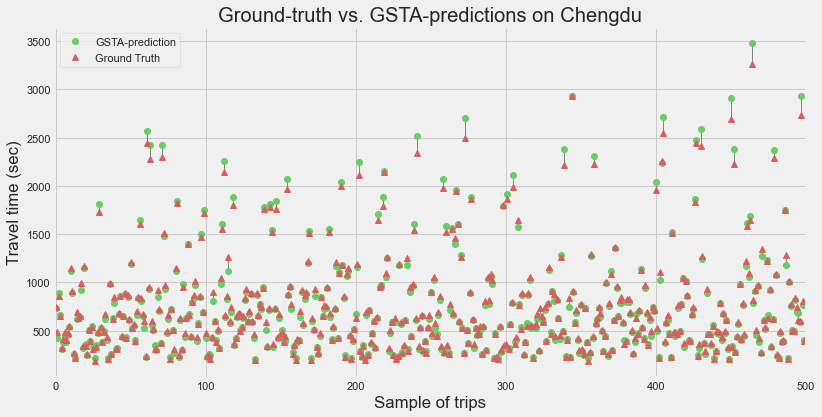

In [36]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['legend.numpoints'] = 1

#generate some random data
pred = y_pred[0:500]
GT =  y_test[0:500]

fig, ax = plt.subplots(figsize=(12,6))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(pred)):
    ax.plot([i,i],[pred[i], GT[i]], c="k", linewidth=0.5)
ax.plot(pred,'o', label='GSTA-prediction', color = 'g')
ax.plot(GT,'^', label='Ground Truth', color = 'r' )

ax.set_xlim((-1,500))
plt.xlabel('Sample of trips')
plt.ylabel('Travel time (sec)')
plt.title('Ground-truth vs. GSTA-predictions on Chengdu')

plt.legend()             
plt.show()

### Save model structure as PNG image

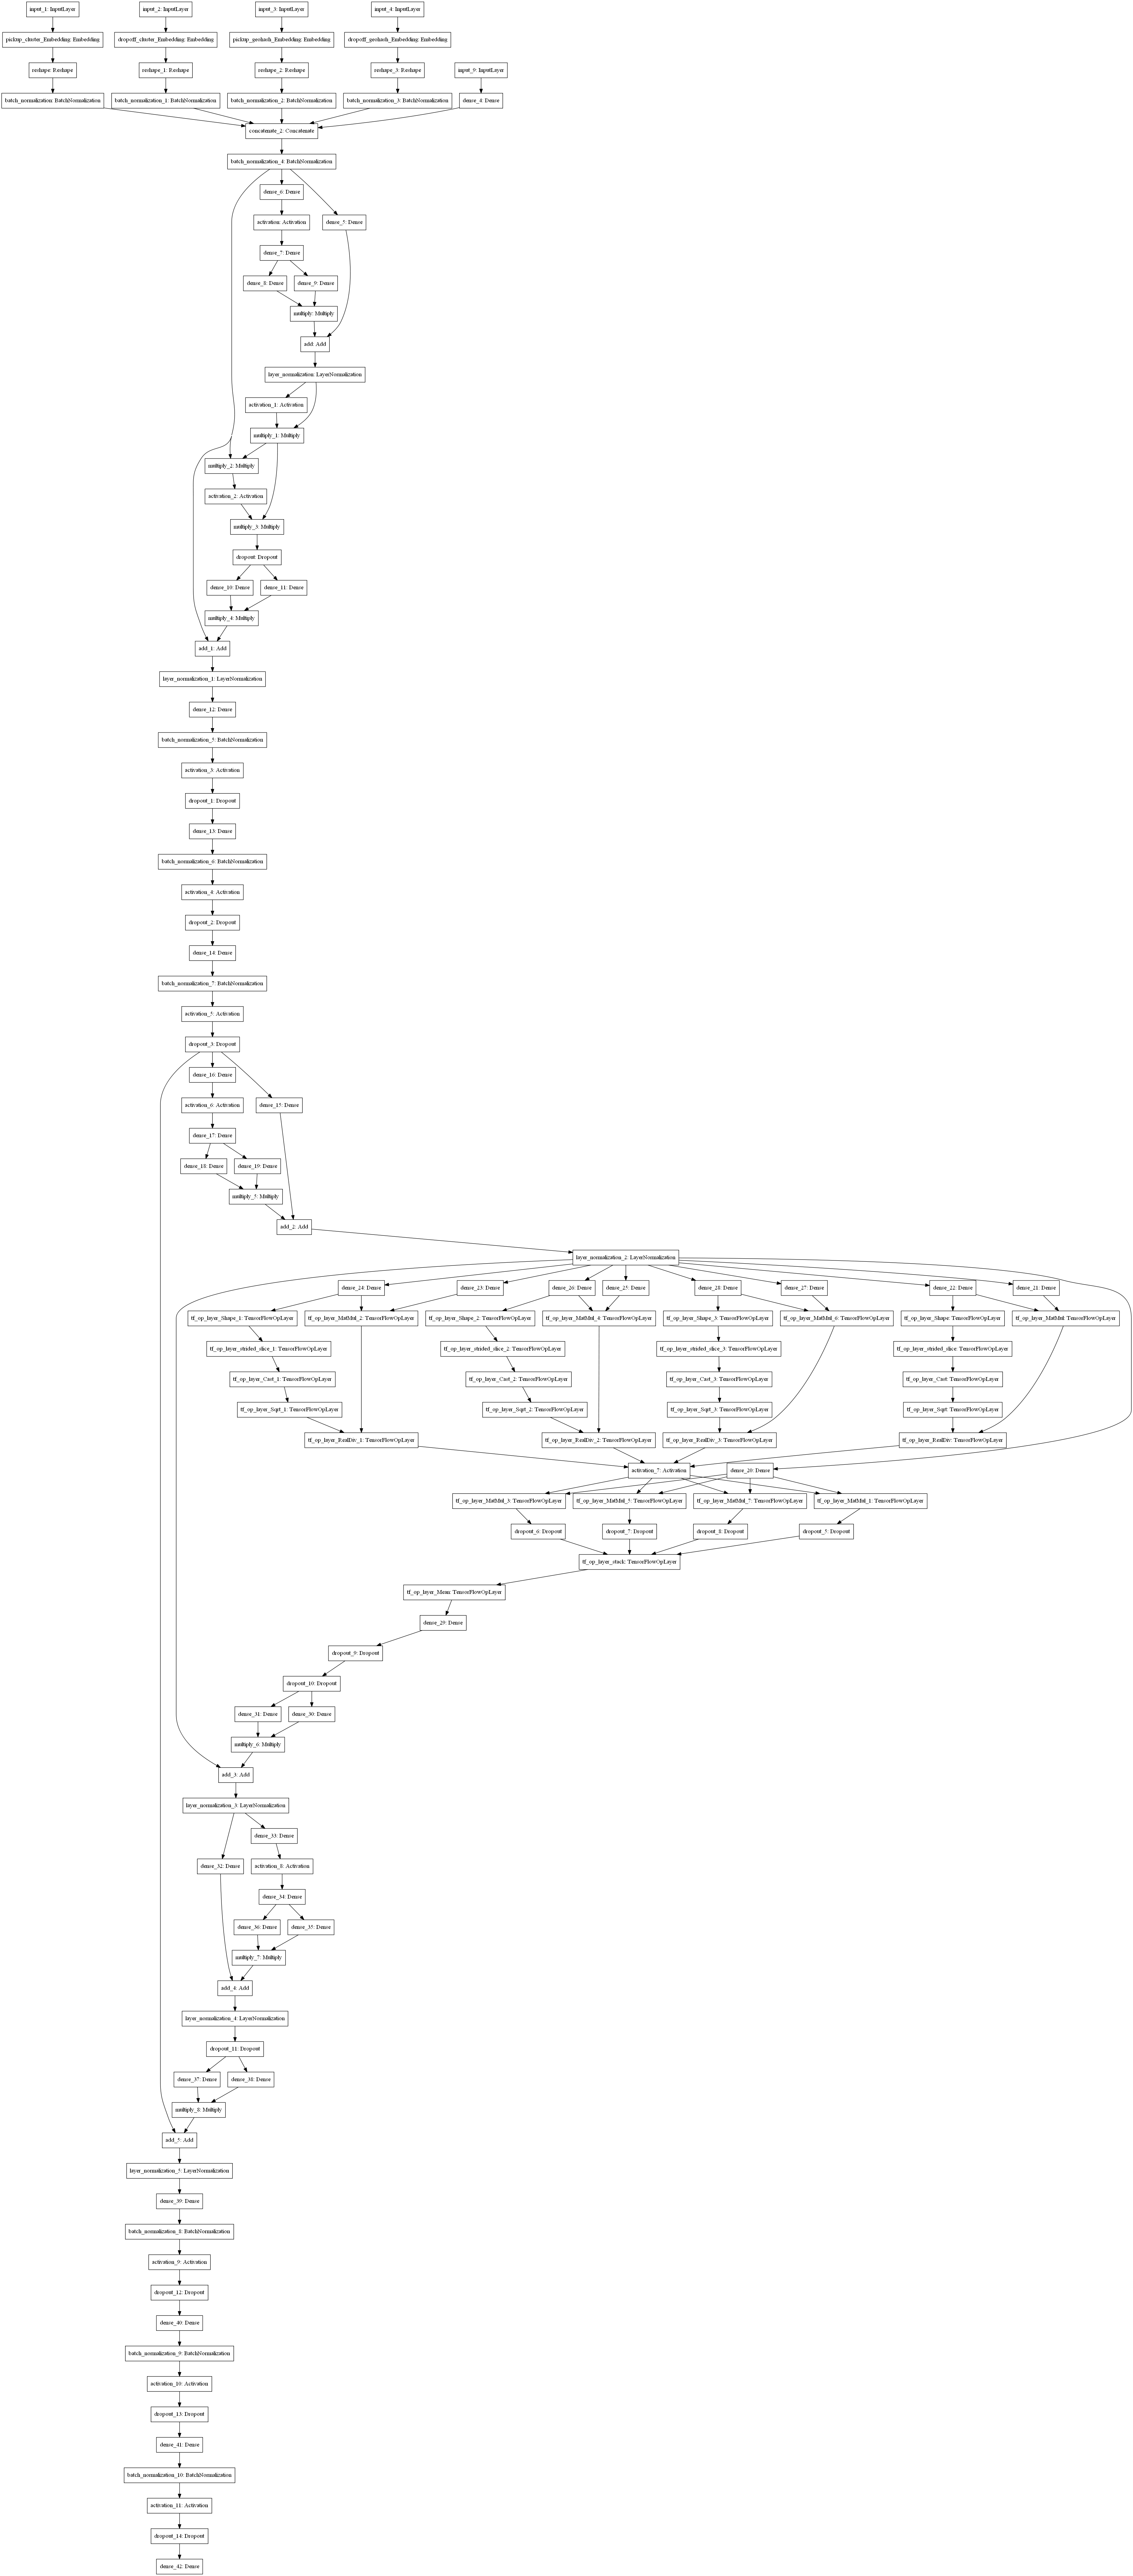

In [28]:
tf.keras.utils.plot_model(
    GSTA,
    to_file="../Models/GSTA.png",
    show_shapes=False,
#     show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)